# Visualizing the results of the model selection

## Initialization

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from dmml_project.model_selection.load_results import load_results, get_results_indices, model_name_from_index, BEAUTIFUL_NAMES
from dmml_project import PROJECT_ROOT, PAPER_IMAGES
from scipy.stats import wilcoxon

search_results = load_results()
results_indices = get_results_indices(search_results)

## Model accuracy distribution (per model kind)

In [2]:

violin_plot_data = pd.DataFrame(columns=["accuracy", "model_kind", "generation"])
generations = ["First", "Second"]
for i, index in enumerate(results_indices):
    gen, model_kind, model_id = index
    result = search_results[gen][model_kind][model_id]
    accuracies = np.array(result[1])
    mean = np.mean(accuracies)
    std = np.std(accuracies)
    for accuracy in accuracies:
        violin_plot_data.loc[len(violin_plot_data)] = [accuracy, BEAUTIFUL_NAMES[model_kind], generations[gen]]

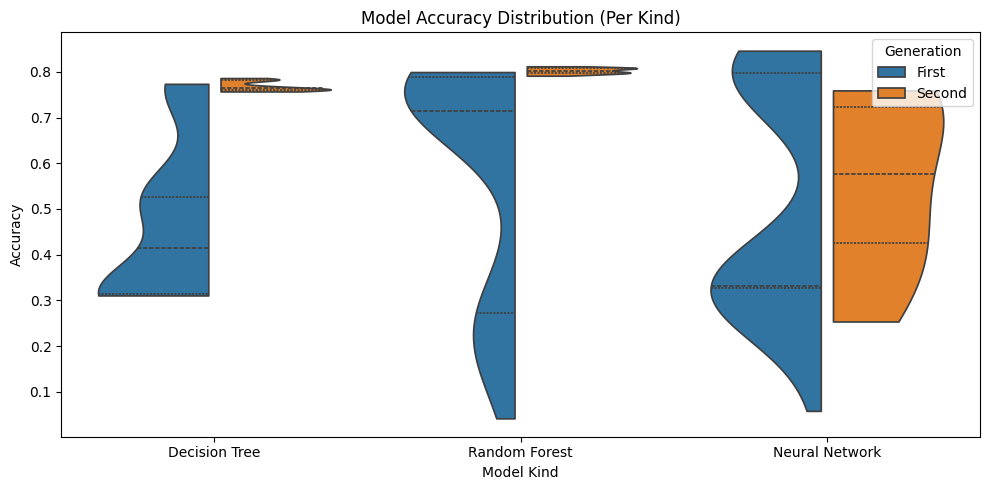

In [3]:
fig = plt.figure(figsize=(10, 5))
plt.title("Model Accuracy Distribution (Per Kind)")
violin_plot_args = {
    "data": violin_plot_data, 
    "x": "model_kind", 
    "hue": "generation", 
    "split": True, 
    "gap": 0.1, 
    "density_norm": "width", 
    "inner": "quartile", 
    "cut": 0
}
sns.violinplot(y="accuracy", **violin_plot_args)
plt.ylabel("Accuracy")
plt.xlabel("Model Kind")
plt.legend(title="Generation")
plt.tight_layout()
plt.savefig(f"{PAPER_IMAGES}/accuracy_distribution.png")
plt.show()

## Model accuracy distribution (per hyperparameter configuration)

In [4]:
kind_to_id = {kind: id for id, kind in enumerate(BEAUTIFUL_NAMES.keys())}
violin_plot_data = [[pd.DataFrame(columns=["accuracy", "model_kind", "hyperparameters"]) for _ in range(len(BEAUTIFUL_NAMES))] for _ in range(len(search_results))]
for i, index in enumerate(results_indices):
    gen, model_kind, model_id = index
    result = search_results[gen][model_kind][model_id]
    for j, accuracy in enumerate(result[1]):
            hyperparameters_name = f"{index[2]}"
            violin_plot_data[gen][kind_to_id[model_kind]].loc[len(violin_plot_data[gen][kind_to_id[model_kind]])] = [accuracy, BEAUTIFUL_NAMES[model_kind], hyperparameters_name]        

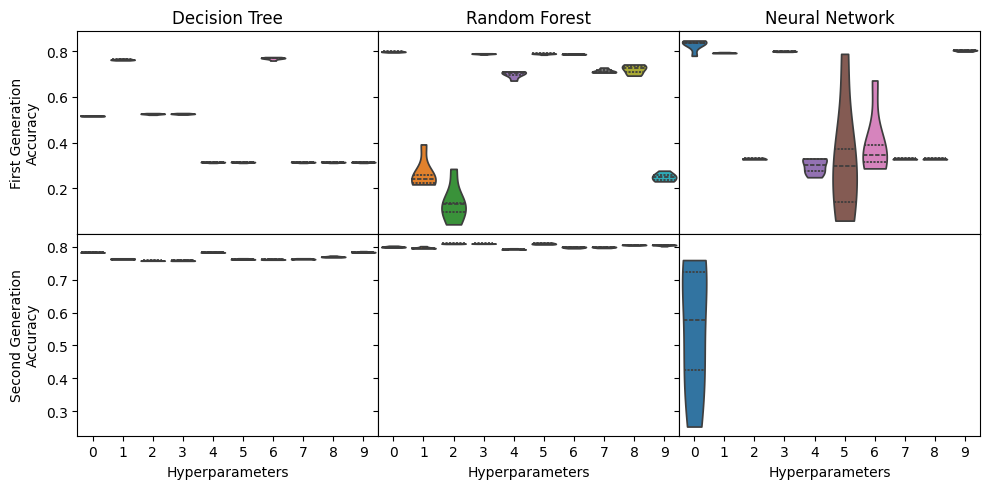

In [5]:
fig, axs = plt.subplots(2, 3, figsize=(10, 5), sharey="row", sharex="col", gridspec_kw={"hspace": 0, "wspace": 0, })
violin_plot_args = {
    "x": "hyperparameters", 
    "y": "accuracy",
    "hue": "hyperparameters", 
    "density_norm": "width", 
    "inner": "quartiles", 
    "cut": 0
}
for i, (_, model_kind) in enumerate(BEAUTIFUL_NAMES.items()):    
    axs[0,i].set_title(model_kind)
    sns.violinplot(data=violin_plot_data[0][i], ax=axs[0,i], **violin_plot_args)
    axs[0,i].set_xlabel(None)
    if i == 0:
        axs[0,i].set_ylabel("First Generation\nAccuracy")
    else:
        axs[0,i].set_ylabel(None)
    sns.violinplot(data=violin_plot_data[1][i], ax=axs[1,i], **violin_plot_args)
    if i == 0:
        axs[1,i].set_ylabel("Second Generation\nAccuracy")
    else:
        axs[1,i].set_ylabel(None)
    axs[1,i].set_xlabel("Hyperparameters")
plt.tight_layout()
plt.savefig(f"{PAPER_IMAGES}/model_selection.png")
plt.show()

## Best model by accuracy per model kind

In [6]:
best_results = {}
for i, index in enumerate(results_indices):
    gen, model_kind, model_id = index
    result = search_results[gen][model_kind][model_id]
    accuracies = result[1]
    mean = np.mean(accuracies)
    if model_kind not in best_results or mean > best_results[model_kind][1]:
        best_results[model_kind] = (index, mean)

for model_kind, (index, mean) in best_results.items():
    print(f"Best {BEAUTIFUL_NAMES[model_kind]}: {model_name_from_index(index)} with mean accuracy {mean*100:.2f}%")

Best Decision Tree: decision_tree-G1-9 with mean accuracy 78.37%
Best Random Forest: random_forest-G1-3 with mean accuracy 80.96%
Best Neural Network: neural_network-G0-0 with mean accuracy 82.89%


## Best models by accuracy (with Wilcoxon test)

Use the Wilcoxon test to find the best models that are statistically different from the others.

In [7]:
import warnings

warnings.filterwarnings("ignore")

p_matrix = np.ones((len(results_indices), len(results_indices)))

def model_name_from_index(index: tuple[int, str, int]) -> str:
    gen, model_kind, i = index
    return f"{model_kind}-G{gen}-{i}"

for i in range(len(results_indices)):
    for j in range(i+1, len(results_indices)):
        gen1, model_kind1, i1 = results_indices[i]
        gen2, model_kind2, i2 = results_indices[j]
        accuracies1 = search_results[gen1][model_kind1][i1][1]
        accuracies2 = search_results[gen2][model_kind2][i2][1]
        _, p = wilcoxon(accuracies1, accuracies2, zero_method="zsplit")
        p_matrix[i, j] = p
        p_matrix[j, i] = p
        #print(f"{model_kind1}-G{gen1}-{i1} and {model_kind2}-G{gen2}-{i2}: p={p:.2f}")
        
best_model_index = None
best_accuracy = 0
for i, index in enumerate(results_indices):
    gen, model_kind, idx = index
    accuracy = np.mean(search_results[gen][model_kind][idx][1])
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model_index = i

print(f"Best model: {model_name_from_index(results_indices[best_model_index])} ({best_accuracy*100:.2f}%)")
for i, index in enumerate(results_indices):
    gen, model_kind, idx = index
    if i == best_model_index:
        continue
    p = p_matrix[best_model_index, i]
    accuracy = np.mean(search_results[gen][model_kind][idx][1])
    if p >= 0.05:
        print(f"{model_name_from_index(index)} ({accuracy*100:.2f}%) is similar to the best (p={p:.3f})")

Best model: neural_network-G0-0 (82.89%)
random_forest-G0-0 (79.71%) is similar to the best (p=0.062)
random_forest-G0-3 (78.82%) is similar to the best (p=0.062)
random_forest-G0-5 (78.84%) is similar to the best (p=0.062)
random_forest-G0-6 (78.68%) is similar to the best (p=0.062)
neural_network-G0-1 (79.27%) is similar to the best (p=0.062)
neural_network-G0-3 (79.86%) is similar to the best (p=0.062)
neural_network-G0-9 (80.20%) is similar to the best (p=0.062)
decision_tree-G1-0 (78.32%) is similar to the best (p=0.062)
decision_tree-G1-4 (78.32%) is similar to the best (p=0.062)
decision_tree-G1-9 (78.37%) is similar to the best (p=0.062)
random_forest-G1-0 (79.96%) is similar to the best (p=0.062)
random_forest-G1-1 (79.67%) is similar to the best (p=0.062)
random_forest-G1-2 (80.95%) is similar to the best (p=0.312)
random_forest-G1-3 (80.96%) is similar to the best (p=0.219)
random_forest-G1-4 (79.26%) is similar to the best (p=0.062)
random_forest-G1-5 (80.94%) is similar to

Plot a heatmap with the p-values of the Wilcoxon test.

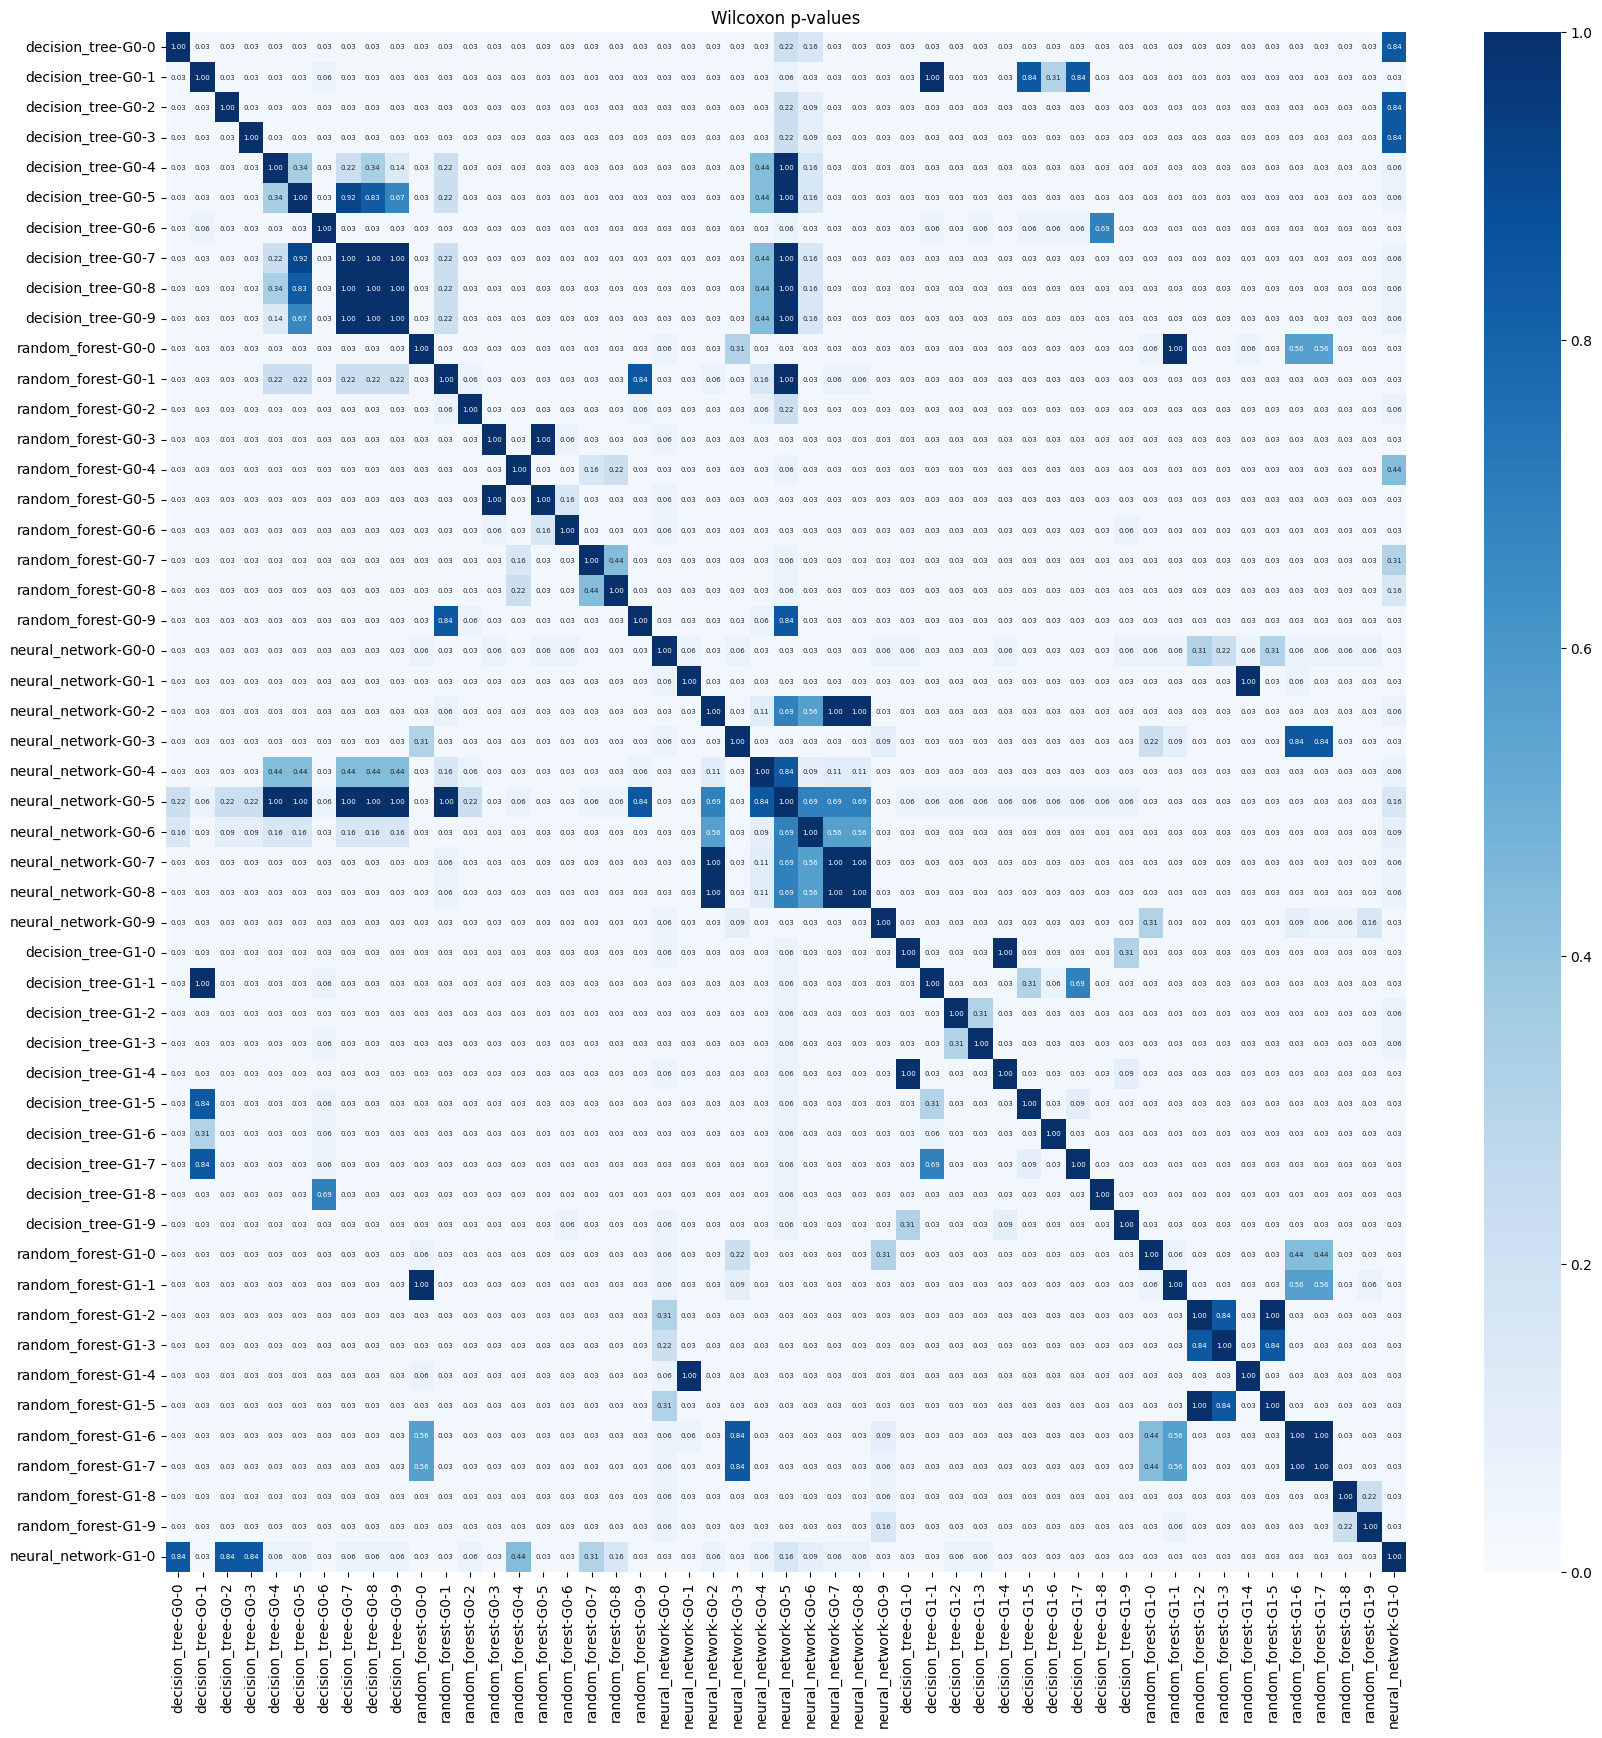

In [8]:
plt.figure(figsize=(20, 20))
plt.title("Wilcoxon p-values")
model_names = [model_name_from_index(i) for i in results_indices]
sns.heatmap(p_matrix, cmap="Blues", annot=True, xticklabels=model_names, yticklabels=model_names, fmt=".2f", annot_kws={"size": 5}, vmin=0, vmax=1)
plt.show()